In [ ]:
!pip install flax

     |████████████████████████████████| 184 kB 5.0 MB/s 
     |████████████████████████████████| 136 kB 35.2 MB/s 
     |████████████████████████████████| 70 kB 6.1 MB/s 


In [ ]:
%matplotlib inline

In [ ]:
import matplotlib.pyplot as plt

import jax 
import jax.numpy as jnp

from flax import linen as nn
from typing import Sequence
import optax

Read [Model-Agnostic Meta-Learning for Fast Adaptation of Deep Networks
](http://proceedings.mlr.press/v70/finn17a.html) by Finn & al. (2017). 
The goals of this exercise are:

1.  To help you understand how automatic differentiation (in particular backprop) can be applied more broadly to "differentiable program". In this specific example, we will see how we can "backprop through" not only the loss and model, but also the optimization procedure itself. What constitutes a "neural network" in this perspective is much more than a stack of sigmoid layers. 
2. To see in action how inductive biases can help us achieve better generalization

We first start by generating a dataset of datasets to train on: aka. a meta training set. You don't have to code this part up.

In [ ]:
def maml_meta_dataset(key, num_datasets=4, num_samples=20, domain=(-5, 5), amplitudes=(0.1, 5), phases=(0, jnp.pi)):
  def sine_wave(x, amplitude=1., phase=0.):
    return amplitude*jnp.sin(x + phase)

  key, subkey = jax.random.split(key)
  Xtrain = jax.random.uniform(key, shape=(num_datasets, num_samples), minval=domain[0], maxval=domain[1])
  Xtest = jax.random.uniform(subkey, shape=(num_datasets, num_samples), minval=domain[0], maxval=domain[1])

  key, subkey = jax.random.split(key)
  amplitudes = jax.random.uniform(key, shape=(num_datasets,), minval=amplitudes[0], maxval=amplitudes[1])
  phases = jax.random.uniform(subkey, shape=(num_datasets,), minval=phases[0], maxval=phases[1])
  Ytrain = jax.vmap(sine_wave)(Xtrain, amplitudes, phases)
  Ytest = jax.vmap(sine_wave)(Xtest, amplitudes, phases)

  return (Xtrain[..., jnp.newaxis], Ytrain), (Xtest[..., jnp.newaxis], Ytest), (sine_wave, amplitudes, phases)

A key difference from our previous exercise in A1 where we were also drawing a dataset of dataset is that this time the underlying function changes. That is, in creating the above meta training set, we hope that our model will be able to learn about the periodic structure of the sine function so as to generalize over that entire space of function. Note that this is a stronger notion than our usual notion of generalization where we care about the performance of a predictor on unseen data points. 

Just as an example, let's draw four sine waves of random amplitude and phase and collect $20$ observation for each one of them:

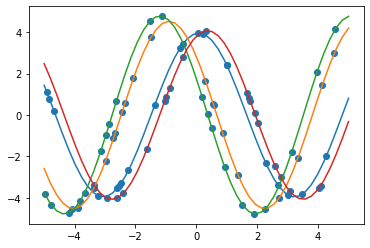

In [ ]:
(Xtrain, Ytrain), _, (sine_wave, amplitudes, phases) = maml_meta_dataset(jax.random.PRNGKey(0))
domain = jnp.linspace(-5, 5)
plt.plot(domain, jax.vmap(sine_wave, in_axes=(None, 0, 0))(domain, amplitudes, phases).T);
plt.scatter(Xtrain, Ytrain)

Per the original MAML paper, we use a model consisting of two dense layers of size $40$ and relu activation.

In [ ]:
class MLP(nn.Module):
  @nn.compact
  def __call__(self, x):
    # IMPLEMENT network
    x = nn.Dense(40)(x)
    x = nn.relu(x)
    x = nn.Dense(40)(x)
    x = nn.relu(x)
    return x

The sine wave problem being a regression problem, we also have to implement the square error loss. 

In [ ]:
def square_error_loss(model):
  def loss(params, xbatch, ybatch):
    # IMPLEMENT
    # Note: I used vmap here. xbatch and ybatch are batches of observations.
    ypred = jax.vmap(model.apply, in_axes=(None, 0))(params, xbatch)
    return jnp.sum((ypred-ybatch)**2)
  return jax.jit(loss)

When working under the usual empirical risk minimization framework, we aim to find a predictor (an "hypothesis") by minimizing the empirical risk, which is a proxy to the true risk. The true objective which we want to solve is:
\begin{align*}
&\text{minimize} \enspace R(\theta) \\
&\text{where} \enspace R(\theta) \triangleq \mathbb{E}\left[ l(Y, f(X; \theta))\right],
\end{align*}
with $X,Y$ drawn from a single fixed (and unknown) joint distrution $P_{X,Y}$. However, all we have access to is a "proxy" function to $R(\theta)$ which we call the empirical risk. We work instead with: 
\begin{align*}
&\text{minimize} \enspace \hat{R}(\theta) \\
&\text{where} \enspace \hat{R}(\theta) \triangleq \frac{1}{|\mathcal{D}|}\sum_{i=1}^{|\mathcal{D}|} l(y_i, f(x_i; \theta)) \enspace .
\end{align*}
In the few-short learning setting of MAML, our risk is defined instead over a distribution of *tasks*. We have: 
\begin{align*}
&\text{minimize}\enspace R(\theta) \\
&\text{where}\enspace R(\theta) = \mathbb{E}_{\tau \sim p_\mathcal{T}}\left[\mathbb{E}_{(X,Y) \sim p_{X,Y|\mathcal{T}}}\left[ l_\mathcal{T}(Y, f(X, 
\mathcal{T};\theta))  \,\middle|\, \mathcal{T} = \tau \right]\right] \enspace .
\end{align*}
More concretely, we sample a task (outer expectation) from a distribution over tasks $p_\tau$. This sampled task $\tau$ then defines a conditional distribution over input-output pairs $p_{X,Y|\mathcal{T}}$. This objective encodes our desire to do well across a **variety of tasks**. 

MAML then makes a specific model assumption about the kind of predictor that we use: we allow ourselves to *fine-tune* our predictor with fresh samples from the target task when predicting. That is, when facing a new task, we allow ourselves to take one (or few) gradient steps from an initial set of parameters and finetune them on data from the new unseen task (a different sine function in our case). This is the one-shot/few-shot learning regime. 

Given a model $f$, it's as if we were to form a new model $g$ from $f$ such that $g$ predicts the target of $x$ by first updating the initial parameters $\theta_0$ using a dataset $\mathcal{D}_\tau$ from the task $\tau$.
The meta empirical risk associated to this problem is:
\begin{align*}
\hat{R}^\text{meta}(\theta_0) &\triangleq \frac{1}{T} \sum_{i=1}^{T} \frac{1}{|\mathcal{D}_{\tau_i}^{\text{test}}|}\sum_{(x_j, y_j) \in \mathcal{D}_{\tau_i}^{\text{test}}} l(y_j, g(x_j; \theta_0, \mathcal{D}_{\tau_i}^\text{train}) \\
g(x_j; \theta_0, \mathcal{D}_{\tau_i}^\text{train}) &\triangleq f(x_j; \theta_0 + \eta D \hat{R}(\theta_0; \mathcal{D}_{\tau_i}^\text{train})) \enspace \\
\hat{R}(\theta_0, \mathcal{D}_{\tau_i}^\text{train}) &\triangleq \frac{1}{|\mathcal{D}_\tau|} \sum_{k=1}^{|\mathcal{D}_{\tau_i}^\text{train}|} l(y_k, f(x_k; \theta_0) \enspace .
\end{align*}
To implement the meta empirical loss we need to have access to a dataset of datasets sampled at random across different tasks. For each such dataset, we then split it into a train and test part. We use the train part to adapt the parameters and then test the performance of the adapted model on the test part. This is a form of built-in cross-validation baked into our meta loss. 


In [ ]:
def maml_loss(loss, alpha):
  """ Wrt to a single train/test dataset"""
  def adaptation_loss(params, xtrain, ytrain, xtest, ytest):
    # IMPLEMENT
    # You need to take one step of gradient descent. 
    # I used jax.tree_util.tree_multimap here because params is a tuple of parameters 
    # return the value of the (base) loss evaluated at the adapter parameters on the test set
    
    direction = jnp.sign(jax.grad(loss(params, xtrain, ytrain)))
    params += direction * alpha

    return loss(params, xtest, ytest)

  def batched_loss(params, xtrain, ytrain, xtest, ytest):
    return jnp.mean(jax.vmap(adaptation_loss, in_axes=(None, 0, 0, 0, 0))(params, xtrain, ytrain, xtest, ytest))

  return batched_loss

 # Meta-learning

In [ ]:
model = MLP()
meta_loss = maml_loss(square_error_loss(model), alpha=1e-2)
optimizer = optax.adam(learning_rate=5e-3)

key, subkey = jax.random.split(jax.random.PRNGKey(6666))
params = model.init(subkey, jax.random.normal(key, (1,))) 
opt_state = optimizer.init(params)

num_meta_steps = 1e3
keys = jax.random.split(key, num_meta_steps)
meta_train_losses = []
for i, key in enumerate(keys):
  (Xtrain, Ytrain), (Xtest, Ytest), _ = maml_meta_dataset(key, 10, 20)
  loss_val, grads = jax.value_and_grad(meta_loss)(params, Xtrain, Ytrain, Xtest, Ytest)
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  if i % 100 == 0:
    print('Loss step {}: '.format(i), loss_val)
  meta_train_losses.append(loss_val)

Loss step 0:  3.682074
Loss step 100:  2.4256608
Loss step 200:  3.9079804
Loss step 300:  2.0404027
Loss step 400:  1.6451591
Loss step 500:  1.8114014
Loss step 600:  0.9730083
Loss step 700:  0.3044226
Loss step 800:  0.799415
Loss step 900:  0.79945296


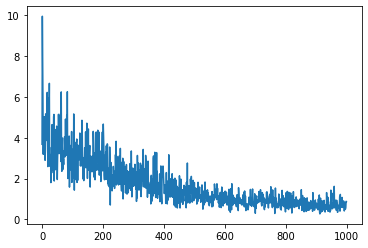

In [ ]:
plt.plot(meta_train_losses)

In [ ]:
alpha = 1e-2
adapted_params = params
loss = square_error_loss(model)

(xtrain, ytrain), (xtest, ytest), (sine_wave, amplitudes, phases) = maml_meta_dataset(key, num_datasets=1, num_samples=100)

val, gradient = jax.value_and_grad(loss)(adapted_params, xtrain, ytrain)
adapted_params = jax.tree_util.tree_multimap(lambda p, g: p - alpha*g, params, gradient)

In [ ]:
domain = jnp.linspace(-5, 5, 100)
pre_adaptation_predictions = jax.vmap(model.apply, in_axes=(None, 0))(params, domain[:, jnp.newaxis])
post_adaptation_predictions = jax.vmap(model.apply, in_axes=(None, 0))(adapted_params, domain[:, jnp.newaxis])

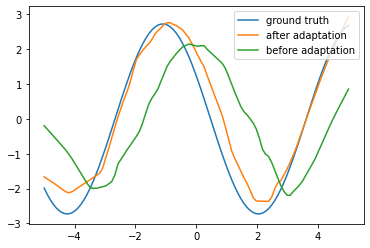

In [ ]:
plt.plot(domain, sine_wave(domain, amplitudes[0], phases[0]), label='ground truth')
plt.plot(domain, post_adaptation_predictions, label='after adaptation')
plt.plot(domain, pre_adaptation_predictions, label='before adaptation')
plt.legend();

# Question

1. Let's think about the chain rule in this particular problem and use a simplification of the underlying math. We have a loss function $L$, and some parameters $\theta$. Our goal is to find some initial parameters $\theta^{(0)}$ such that after $k$ steps of adaptation the resulting parameters give us a small loss on some test loss function $J$. That is, we want to:
\begin{align*}
&\text{minimize}\enspace J(\theta^{(k)}) \\
&\text{where} \enspace \theta^{(t+1)} = \theta^{(t)} - \eta DL(\theta^{(t)}), \enspace t=0,...,k \enspace .
\end{align*}
Use the chain rule of calculus to write the expression for the gradient of the meta-loss with respect to $\theta^{(0)}$. **Hint**: the corresponding function composition looks like $(J \circ f \circ ... \circ f)(\theta^{(0)})$ where $f$ is the gradient descent step, ie a function of the form $f(\theta) = \theta - \eta L(\theta)$.

Discuss the computational implications of having to evaluate the above derivative.

Our parameters are updated as follows

\begin{gather}
  \theta^1 = \theta^0 - \eta \nabla_{\theta} \mathcal{L} (\theta^0)\\
  \theta^2 = \theta^1 - \eta \nabla_{\theta} \mathcal{L} (\theta^1)\\
  \theta^3 = \theta^2 - \eta \nabla_{\theta} \mathcal{L} (\theta^2)\\
  ...\\
  \theta^t = \theta^{t-1} - \eta \nabla_{\theta} \mathcal{L} (\theta^{t-1})
\end{gather}

<!-- The meta-loss may be written as the average base loss over the adapted datasets:


\begin{gather}
  \nabla_{\theta} L &= \nabla \sum_i \mathcal{L}_i(\theta^t)\\ 
\end{gather}  -->

[...]

The above derivative is a composition of loss functions that quickly becomes computationaly expensive, which is a motivation for the first order aproximation.
